<div class="alert alert-success">
    <center> <h1> <font size="8"> Multivariate Normal Example </font> </h1> </center>
    <center> <h1> <font size="5"> Low-Rank Approximation of $\Sigma$  </font> </h1> </center>
</div>

<br/>
<br/>

In this example, we model and predict all parameters of a trivariate ($Y_{D}=3$) Normal distribution. The conditional means $\mathbf{\mu}(x) \in \mathbb{R}^{D}$ and the conditional covariance matrix $\mathbf{\Sigma}(x) \in \mathbb{R}^{D \times D}$ are given as follows

$$
\mathbf{\mu}(x)=\begin{pmatrix}\mu_{1}(x) \\ \mu_{2}(x) \\ \mu_{3}(x)\end{pmatrix}, \qquad \qquad  
\mathbf{\Sigma}(x)= \begin{pmatrix}
\sigma^{2}_{11}(x) & \rho_{1,2}(x)\sigma_{1}(x)\sigma_{2}(x) & \rho_{1,3}(x)\sigma_{1}(x)\sigma_{3}(x) \\
\rho_{2,1}(x)\sigma_{2}(x)\sigma_{1}(x) & \sigma^{2}_{22}(x) & \rho_{2,3}(x)\sigma_{2}(x)\sigma_{3}(x) \\
\rho_{3,1}(x)\sigma_{3}(x)\sigma_{1}(x) & \rho_{3,2}(x)\sigma_{3}(x)\sigma_{2}(x) &  \sigma^{2}_{33}(x)
\end{pmatrix}
$$

While efficient for low to medium dimensions of $D$, the computational cost of the Cholesky-decomposition becomes prohibitive in high-dimensional settings. To reduce the computational overhead, the covariance matrix $\mathbf{\Sigma}$ can be approximated via the sum of a diagonal matrix $\mathbf{K} \in \mathbb{R}^{D \times D}_{+}$ and a unrestricted low-rank matrix $\mathbf{V} \in \mathbb{R}^{D \times r}$ 

$$
\begin{align}
\mathbf{\Sigma} &= \mathbf{K} + \mathbf{V}\mathbf{V}^{T}  \\
                  &= \begin{bmatrix}
                   \exp(\text{K}_{1}) & \dots  & 0\\
                  \vdots & \ddots & \vdots\\
                  0 & \dots  & \exp(\text{K}_{D})
                  \end{bmatrix} + 
                  \begin{bmatrix}
                   \text{V}_{1}  \\
                   \vdots  \\
                   \text{V}_{D} \\
                   \end{bmatrix} 
                  \begin{bmatrix}
                   \text{V}_{1}  \\
                   \vdots  \\
                   \text{V}_{D} \\
                  \end{bmatrix}^{T}
\end{align}
$$

where $\exp(\cdot)$ ensures all diagonal entries of $\mathbf{K}$ to be strictly positive and the rank parameter $r$ governs the quality of the approximation. The computational efficiency of this approach results from the fact that the rank parameter $r$ can typically be chosen much smaller than the number of target variables $D$. The following table shows the number of parameters $K$ to estimate for a Multivariate Gaussian for the Cholesky $D(D+3)/2$ and the low-rank covariance matrix approximation $D(2+r)$ as functions of the response dimension $\mbox{Y}_{D}$.

<center>

| $\mbox{Y}_{D}$  | Cholesky     |  LRA(r=5)  | LRA(r=10)   | LRA(r=20)  |
|:---------------:|:------------:|:----------:|:-----------:|:----------:|
|        2        | 5            | 14         | 24          | 44         |
|        5        | 20           | 35         | 60          | 110        |
|       10        | 65           | 70         | 120         | 220        |
|       50        | 1,325        | 350        | 600         | 1,100      |
|       100       | 5,150        | 700        | 1,200       | 2,200      |
|       500       | 125,750      | 3,500      | 6,000       | 11,000     |
|      1,000      | 501,500      | 7,000      | 12,000      | 22,000     |
|     10,000      | 50,015,000   | 70,000     | 120,000     | 220,000    |

</center>

The table shows that the number of parameters increases exponentially for the Cholesky-decomposition, while the relationship is only linear for the low-rank approximation, making it more suitable for high-dimensional settings. Since XGBoostLSS is based on a *one vs. all estimation strategy*, where a separate tree is grown for each distributional parameter, **estimating many parameters for a large dataset can become computationally extremely expensive**. For more details, we refer to our related paper **[März, Alexander (2022), *Multi-Target XGBoostLSS Regression*](https://arxiv.org/abs/2210.06831)**.

<br>
<br>

# Multivariate Gaussian Regression (Low-Rank Approximation)

# Imports

In [17]:
from xgboostlss.model import *
from xgboostlss.distributions.MVN_LoRa import *
from xgboostlss.datasets.data_loader import load_simulated_multivariate_gaussian_data

from sklearn.model_selection import train_test_split
import pandas as pd
import multiprocessing
import plotnine
from plotnine import *
plotnine.options.figure_size = (18, 9)
n_cpu = multiprocessing.cpu_count()

# Data

In [2]:
data_sim = load_simulated_multivariate_gaussian_data()

# Create 60%, 20%, 20% split for train, validation and test 
train, validate, test = np.split(data_sim.sample(frac=1,random_state=123), [int(0.6*len(data_sim)), int(0.8*len(data_sim))])

# Train
x_train = train.filter(regex="x")
y_train = train.filter(regex="y").values
n_targets = y_train.shape[1]
dtrain = xgb.DMatrix(x_train, label=y_train, nthread=n_cpu)

# Validation
x_eval = validate.filter(regex="x")
y_eval = validate.filter(regex="y").values
deval = xgb.DMatrix(x_eval, label=y_eval, nthread=n_cpu)

# Test
x_test = test.filter(regex="x")
y_test = test.filter(regex="y").values
dtest = xgb.DMatrix(x_test, nthread=n_cpu)

# Distribution Selection

In [3]:
# Specifies a multivariate Normal distribution, using the Low-Rank approximation. See ?MVN_LoRa for details.
xgblss = XGBoostLSS(
    MVN_LoRa(D=n_targets,                      # Specifies the number of targets
             rank=2,                           # Specifies the rank 
             stabilization="None",             # Options are "None", "MAD", "L2".
             response_fn="exp",                # Function to transform the lower-triangular factor of the covariance, e.g., "exp" or "softplus".
             loss_fn="nll"                     # Loss function, i.e., nll.
            )               
)

# Hyper-Parameter Optimization

Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are specified, max_depth is not used when gblinear is sampled, since it has no such argument.

In [4]:
param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=120,            # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=20,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-06-21 16:08:24,386] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization
C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-06-21 16:10:58,756] Trial 0 finished with value: 4715.1293944 and parameters: {'eta': 0.011583802021120177, 'max_depth': 6, 'gamma': 4.298718115769394e-07, 'subsample': 0.4389977358989794, 'colsample_bytree': 0.2937778261408931, 'min_child_weight': 2.0751720031622087e-06, 'booster': 'gbtree'}. Best is trial 0 with value: 4715.1293944.
[I 2023-06-21 16:13:46,045] Trial 1 finished with value: 5506.9937502 and parameters: {'eta': 0.0006950905309493148, 'max_depth': 9, 'gamma': 0.0005319868904179334, 'subsample': 0.22711708632866234, 'colsample_bytree': 0.6606216557241239, 'min_child_weight': 1.7073883542887016e-07, 'booster': 'gbtree'}. Best is trial 0 with value: 4715.1293944.
[I 2023-06-21 16:16:39,844] Trial 2 finished with value: 5601.6347656 and parameters: {'eta': 0.00010131220313381806, 'max_depth': 9, 'gamma': 6.680066899855348e-06, 'subsample': 0.8351289737147574, 'colsample_bytree': 0.6594140272475766, 'min_child_weight': 1.990513192590756e-06, 'booster': 'gbtree'}. Best

# Model Training

In [5]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Add evaluation set
eval_set = [(dtrain,"train"), (deval,"evaluation")]
eval_result = {}
            
# Train Model with optimized hyperparameters
xgblss.train(
    opt_params,
    dtrain,
    num_boost_round=n_rounds,
    evals=eval_set, 
    evals_result=eval_result,
    verbose_eval=False
)

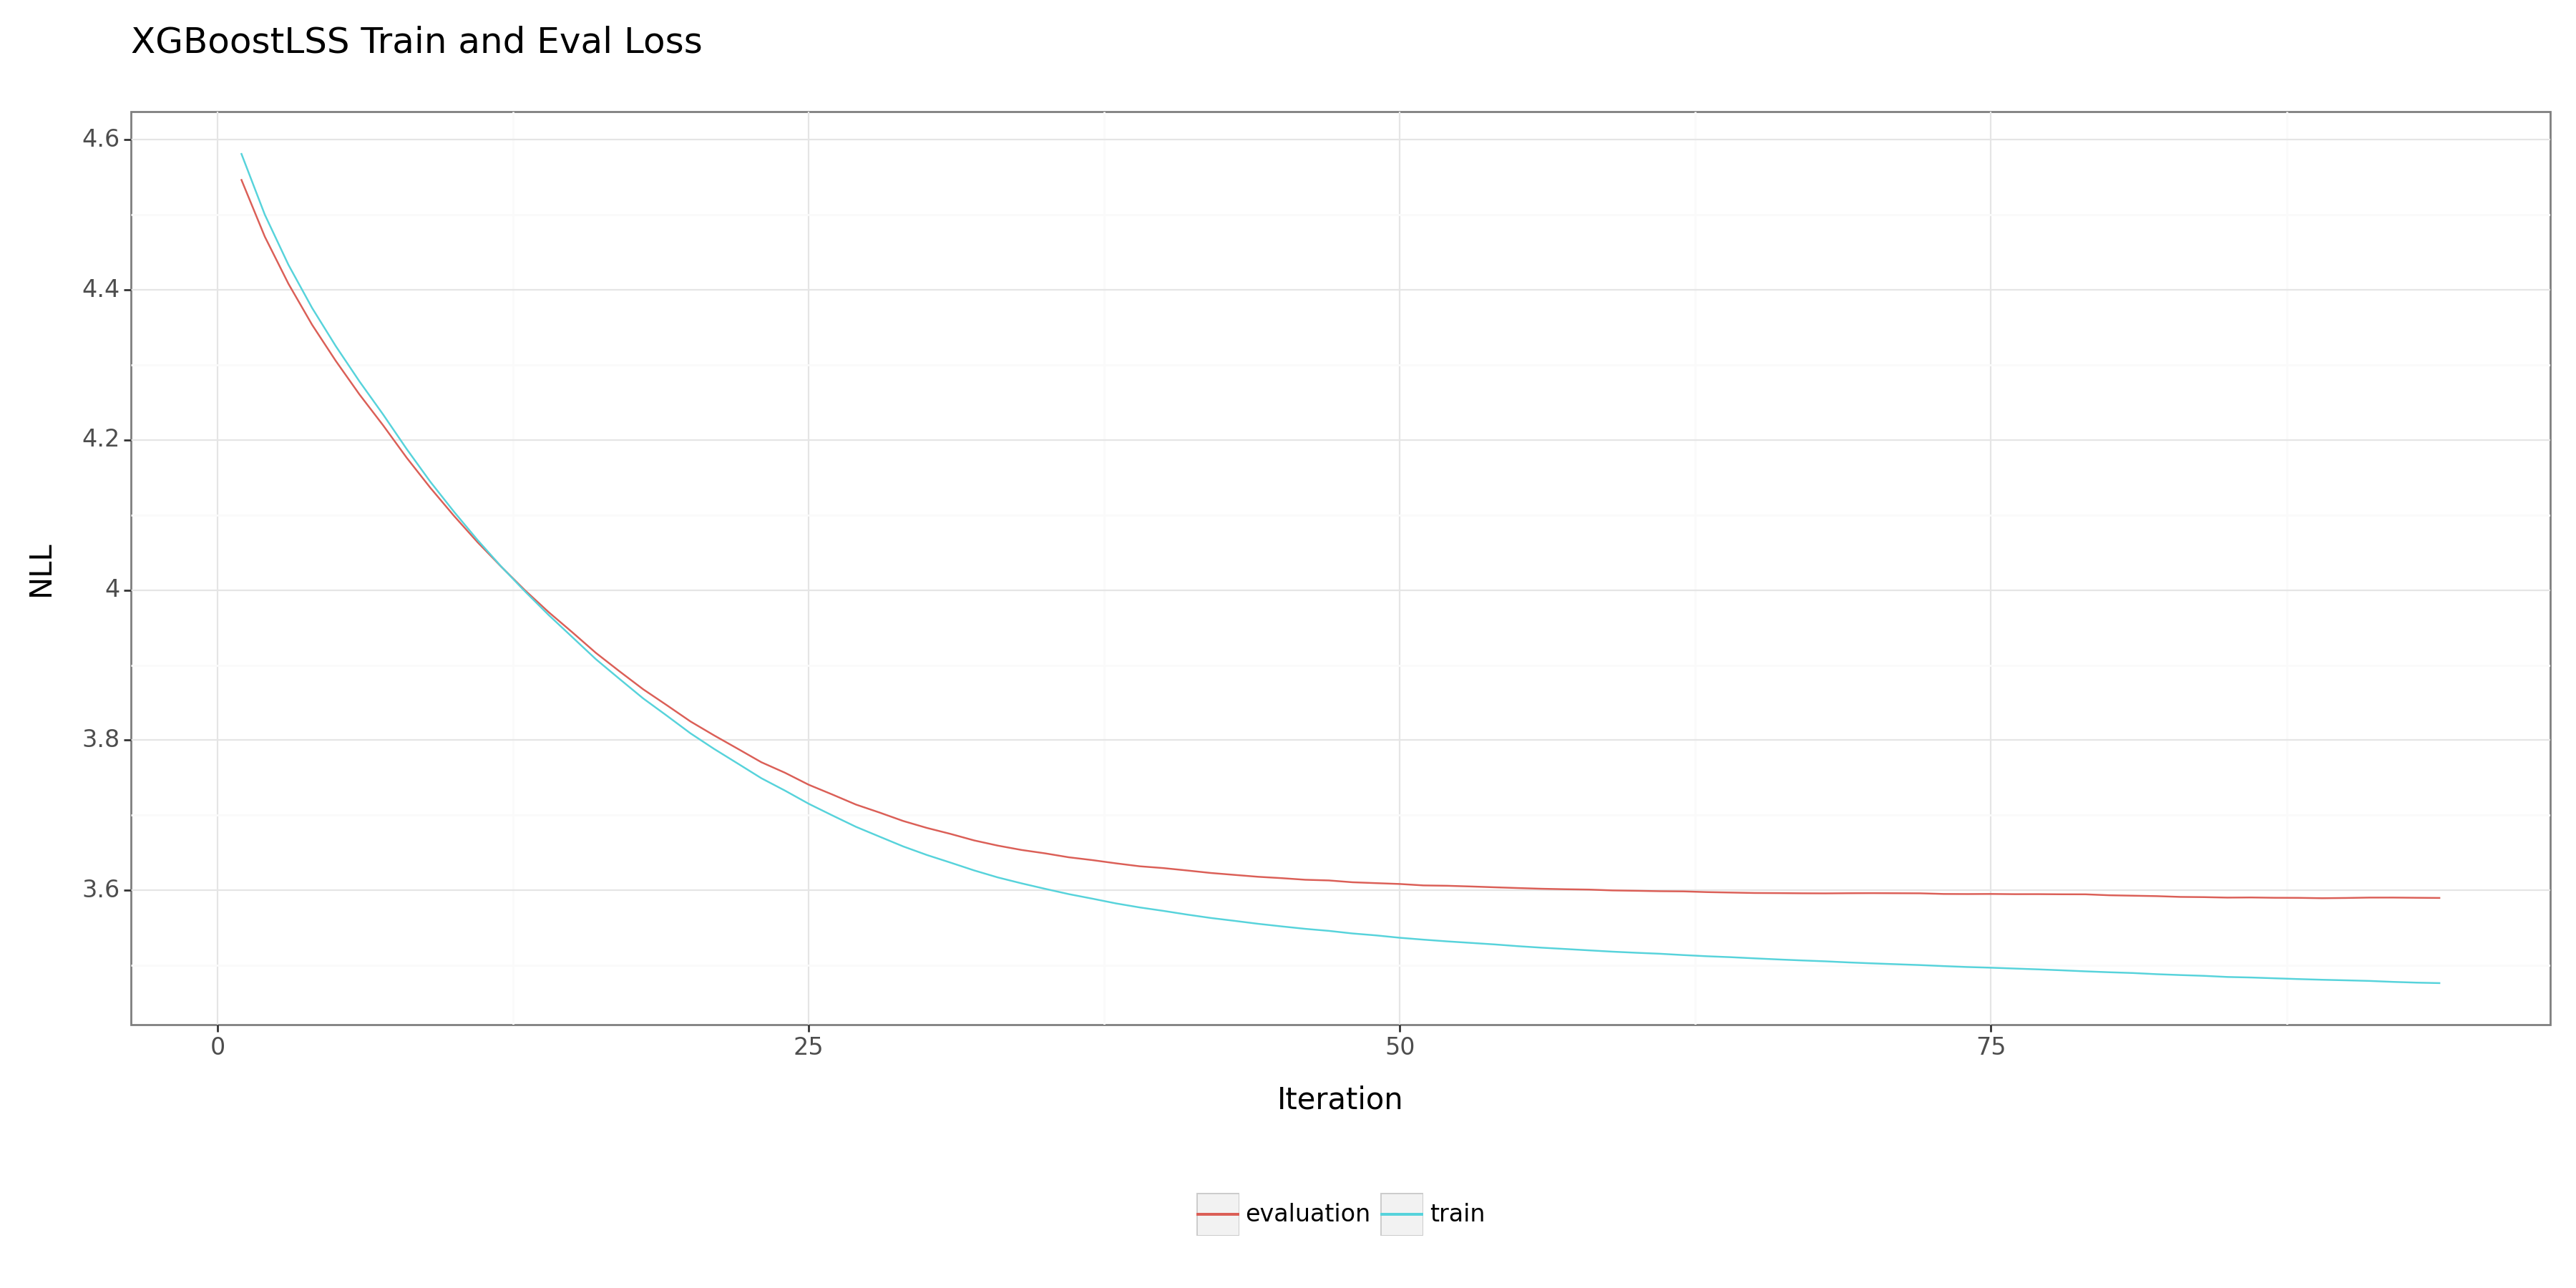

<Figure Size: (1800 x 900)>

In [6]:
# Note that XGBoostLSS uses NLL.sum() instead of NLL.mean() for training, so that train-nll and evaluation-nll are not comparable. Hence we manually adjust them.
n_train = y_train.shape[0],
n_eval =  y_eval.shape[0]

eval_df = pd.DataFrame.from_dict({"train": np.array(eval_result["train"]["nll"]) / n_train,
                                  "evaluation": np.array(eval_result["evaluation"]["nll"]) / n_eval
                                 })
eval_df["iter"] = eval_df.index + 1
eval_df = eval_df.melt(id_vars="iter")

(
    ggplot(eval_df,
           aes(x="iter",
               y="value",
               color="variable")) + 
    geom_line() + 
    labs(title="XGBoostLSS Train and Eval Loss",
         x="Iteration",
         y="NLL") + 
    theme_bw(base_size=15) + 
    theme(legend_position="bottom",
          legend_title = element_blank()
         )
)

# Prediction

In [7]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [8]:
pred_samples.head()

,target,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,y1,0.720453,0.219559,0.203310,0.038646,0.650132,0.540127,0.390709,0.726713,-0.118624,...,0.612824,-0.818095,1.054877,0.455723,1.292276,0.860557,0.644951,1.392718,0.183303,-1.010546
1,y1,-0.583022,0.400478,-0.323243,0.528045,-0.135249,1.090619,-0.326025,-0.636557,0.001466,...,-0.605673,1.553781,0.941824,0.847325,-0.615416,0.489119,-0.954644,0.374669,0.623887,-0.998212
2,y1,1.121288,0.317229,-0.118038,-0.015100,0.825524,-0.487331,0.839285,-1.228601,0.486604,...,-0.753202,0.975157,-1.003511,-0.249833,-0.560907,0.333757,1.036261,1.661406,2.466741,-1.329416
3,y1,-0.127291,-0.805017,2.306045,-0.402454,-0.303588,0.470358,-0.528857,-0.005220,-0.874630,...,-0.423066,-1.179363,0.021967,-0.180361,1.730831,0.428007,-0.971902,-0.424471,0.346657,1.438614
4,y1,-0.060891,0.569407,-1.067708,-0.070908,0.256457,-1.235300,-0.835309,0.592696,0.790054,...,0.986536,0.347290,0.409428,-0.343989,0.901657,0.095329,0.625500,0.572105,-0.582210,0.377969


In [9]:
pred_samples.tail()

,target,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
5995,y3,1.093513,1.248744,1.656025,1.603395,0.759864,-1.444430,1.273965,1.765574,-1.234340,...,0.384926,0.221698,0.430155,-0.108825,1.067578,1.143559,1.480677,0.785885,1.445105,-0.113264
5996,y3,-1.568412,-0.050369,0.171015,2.525167,1.693829,3.830850,1.348235,0.746293,3.208230,...,1.784155,2.328073,1.076505,2.230423,-1.546146,2.476250,1.552564,2.374282,0.925256,3.698507
5997,y3,1.479440,2.106636,3.047795,3.013000,2.365144,1.865687,1.429210,0.616888,1.258692,...,0.235736,0.608137,4.174130,1.384145,2.582013,1.513692,2.124291,1.803355,2.774794,1.127500
5998,y3,-0.629701,1.380290,0.497511,1.489036,1.960947,1.129145,2.096743,0.438941,-1.860455,...,-1.133028,-0.046983,1.347535,1.730018,-1.383197,1.529693,0.275051,2.311301,-0.659254,1.239904
5999,y3,0.965730,1.216989,0.889431,1.308722,-0.543194,4.134661,3.586283,1.193535,0.364990,...,0.433430,3.568290,1.085583,3.606496,1.287189,1.835434,2.961228,2.920355,1.679133,-0.364212


In [10]:
pred_quantiles.head()

,target,quant_0.05,quant_0.95
0,y1,-0.700078,1.353007
1,y1,-1.252096,1.080083
2,y1,-1.239331,2.147453
3,y1,-1.214470,1.866392
4,y1,-1.149287,1.509025


In [11]:
pred_params.head()

,location_1,location_2,location_3,scale_1,scale_2,scale_3,rho_12,rho_13,rho_23
0,0.298273,1.301121,0.964177,0.601496,1.484843,1.200265,0.730067,0.451249,0.693615
1,-0.120719,0.613711,1.613910,0.701295,1.837523,1.988150,0.904230,0.689400,0.667632
2,0.359174,0.478553,1.630007,1.051336,1.761174,1.077264,0.708636,0.725149,0.523023
3,0.325684,0.478553,1.630007,0.941796,1.478989,0.970558,0.853838,0.646047,0.548437
4,0.115142,0.613039,1.761861,0.799810,1.739506,1.349333,0.776335,0.743189,0.585242


# SHAP Interpretability

Since XGboostlss estimates the covariance matrix $\mathbf{\Sigma} = \mathbf{K} + \mathbf{V}\mathbf{V}^{T}$ via the low-rank approximation, **interpretability is only sensible for the location parameters**. The following parameters have been estimated

In [12]:
list(xgblss.dist.param_dict.keys())

['location_1',
 'location_2',
 'location_3',
 'cov_factor_1',
 'cov_factor_2',
 'cov_factor_3',
 'cov_factor_4',
 'cov_factor_5',
 'cov_factor_6',
 'cov_diag_1',
 'cov_diag_2',
 'cov_diag_3']

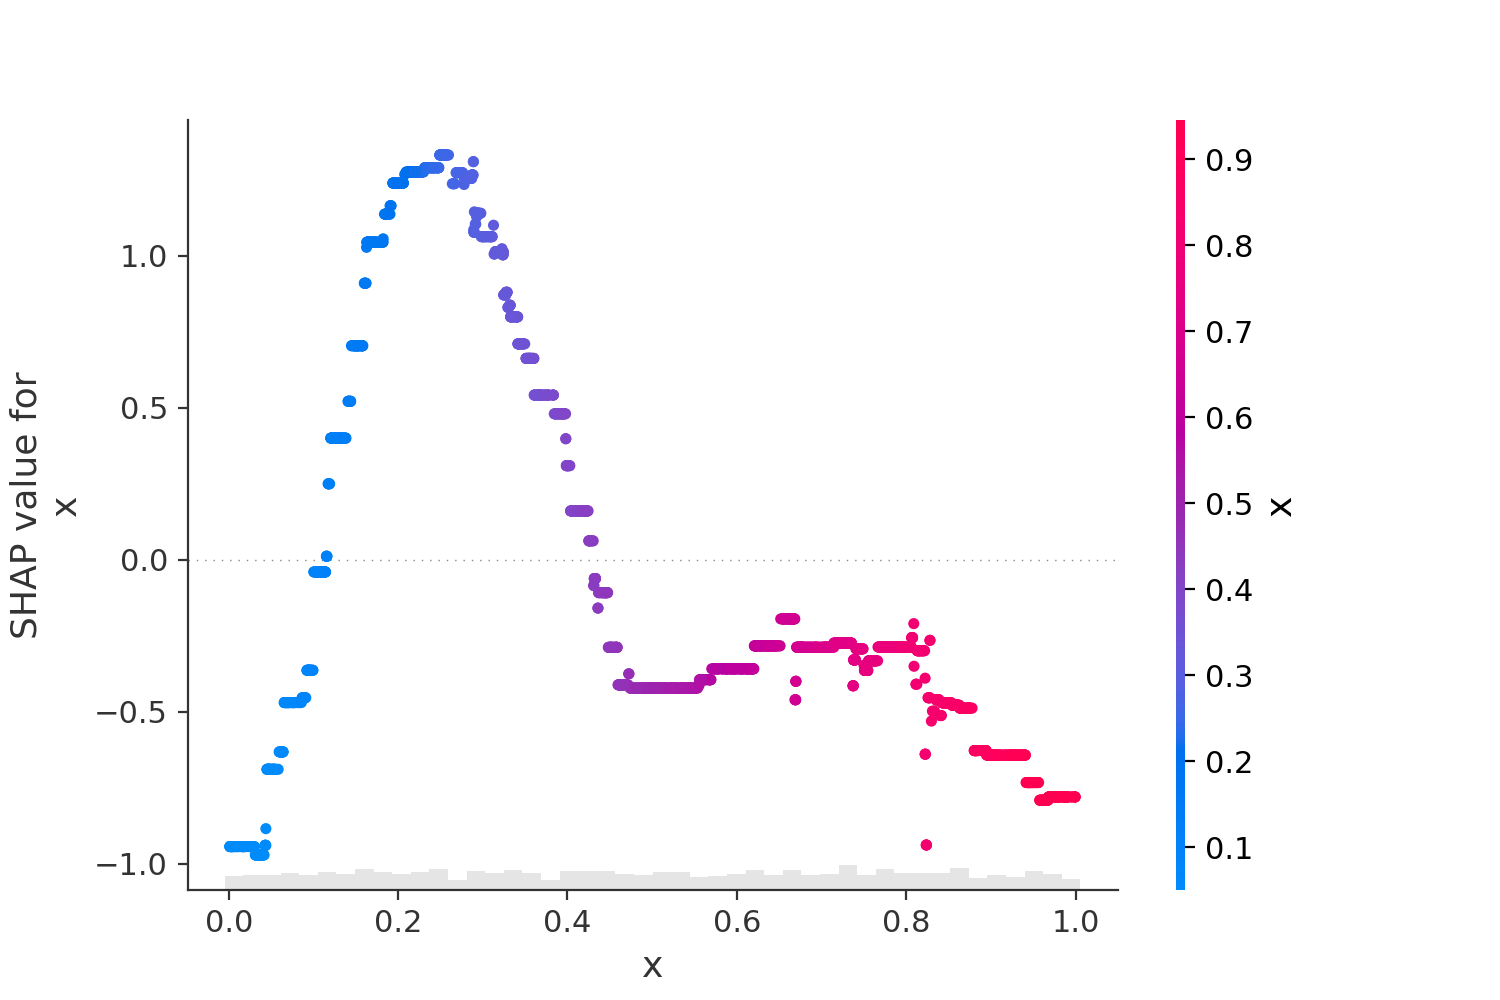

In [13]:
# Partial Dependence Plot of how x acts on location_2
xgblss.plot(x_test,
            parameter="location_2",
            feature="x",
            plot_type="Partial_Dependence")

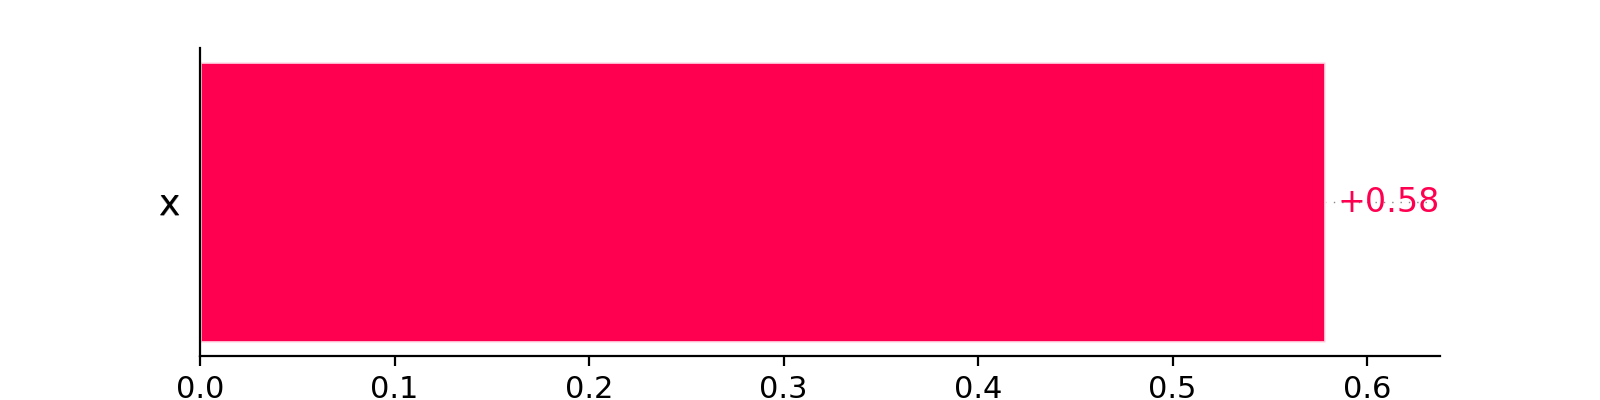

In [14]:
# Feature Importance of location_2 parameter
xgblss.plot(x_test,
            parameter="location_2",
            plot_type="Feature_Importance")

# True vs. Predicted Distributional Parameters

In the following figure, we compare the true parameters of the multivariate Gaussian with the ones predicted by XGBoostLSS. The below figure shows that the estimated parameters closely match the true ones.

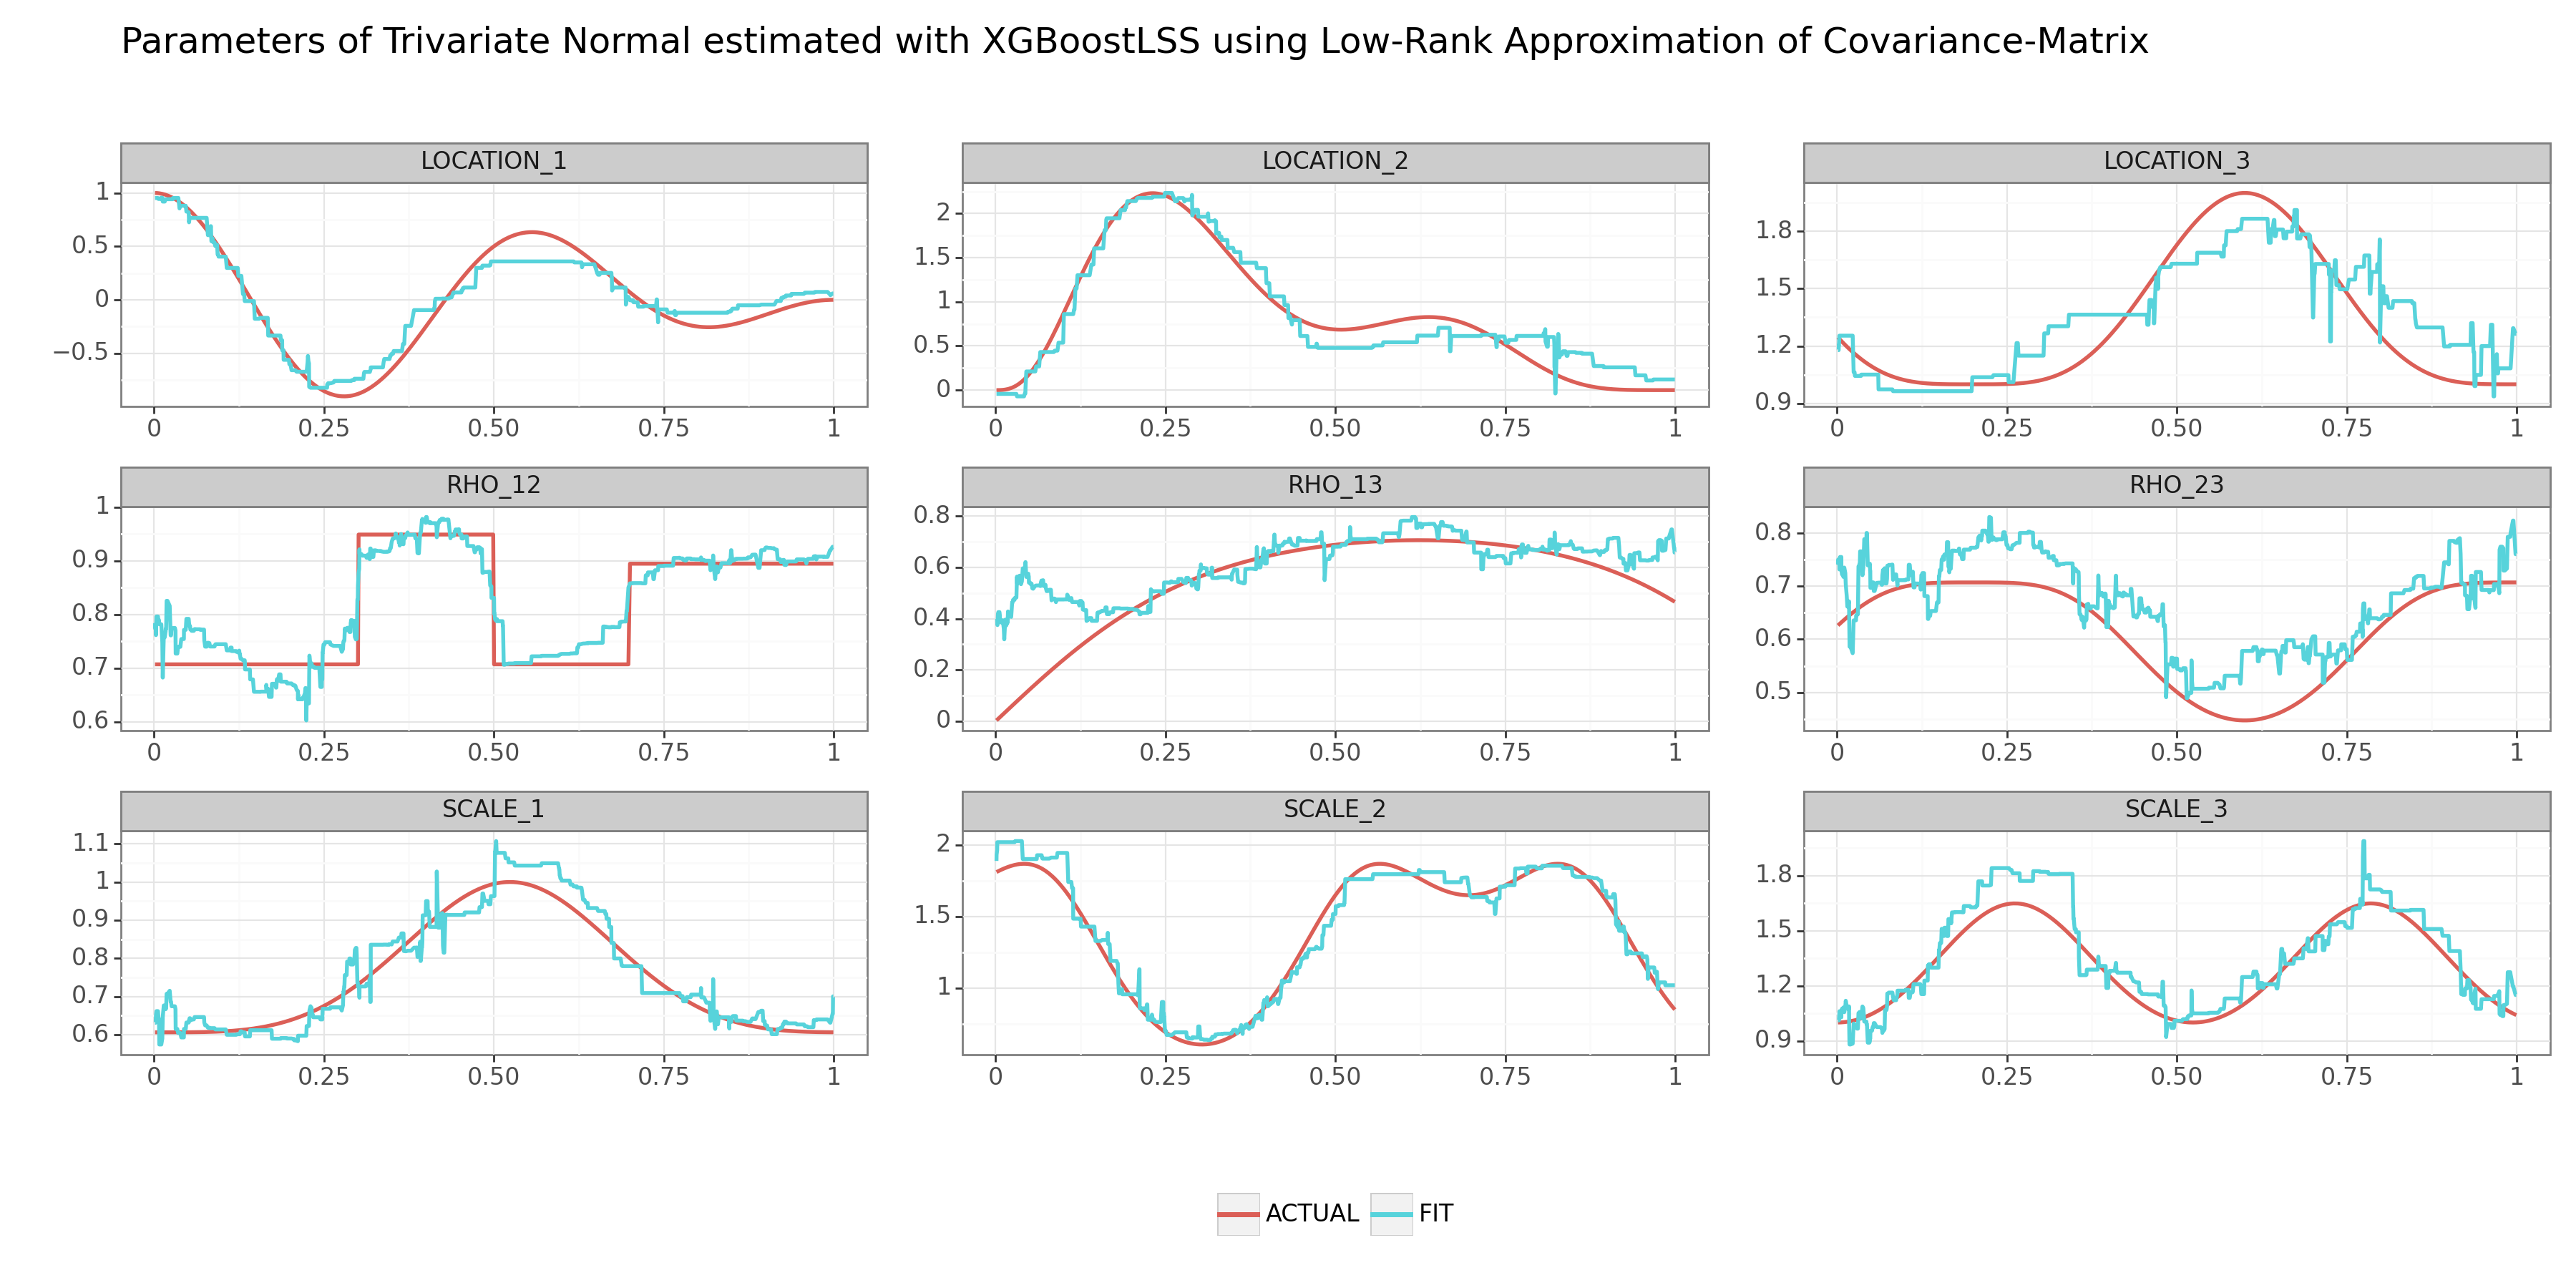

In [15]:
dist_params = pred_params.columns.tolist()
pred_params["x"] = test["x"].values
drop_cols = [resp for resp in list(test.columns) if "y" in resp]

plot_df_actual = pd.melt(test.drop(columns=drop_cols, axis=0),
                         id_vars="x",
                         value_vars=dist_params)

plot_df_actual["type"] = "ACTUAL"

plot_df_fitted = pd.melt(pred_params,
                         id_vars="x",
                         value_vars=dist_params)

plot_df_fitted["type"] = "FIT"

plot_df = pd.concat([plot_df_actual, plot_df_fitted])   

plot_df["variable"] = plot_df.variable.str.upper()


plot_params = (ggplot(plot_df,
                      aes(x="x",
                          y="value",
                          color="type")) +
               geom_line(size=1.1) + 
               facet_wrap("variable",
                          # ncol=2,
                          scales="free") + 
               labs(title="Parameters of Trivariate Normal estimated with XGBoostLSS using Low-Rank Approximation of Covariance-Matrix\n",
                    x="",
                    y="") + 
               theme_bw(base_size=15) + 
               theme(legend_position="bottom",
                     legend_title = element_blank()
                    )
              )

print(plot_params)

# Actual vs. Predicted
Since we predict the entire conditional distribution, we can overlay the point predictions with predicted densities, from which we can also derive quantiles of interest. We use the first response $y_{1}$ as an example.

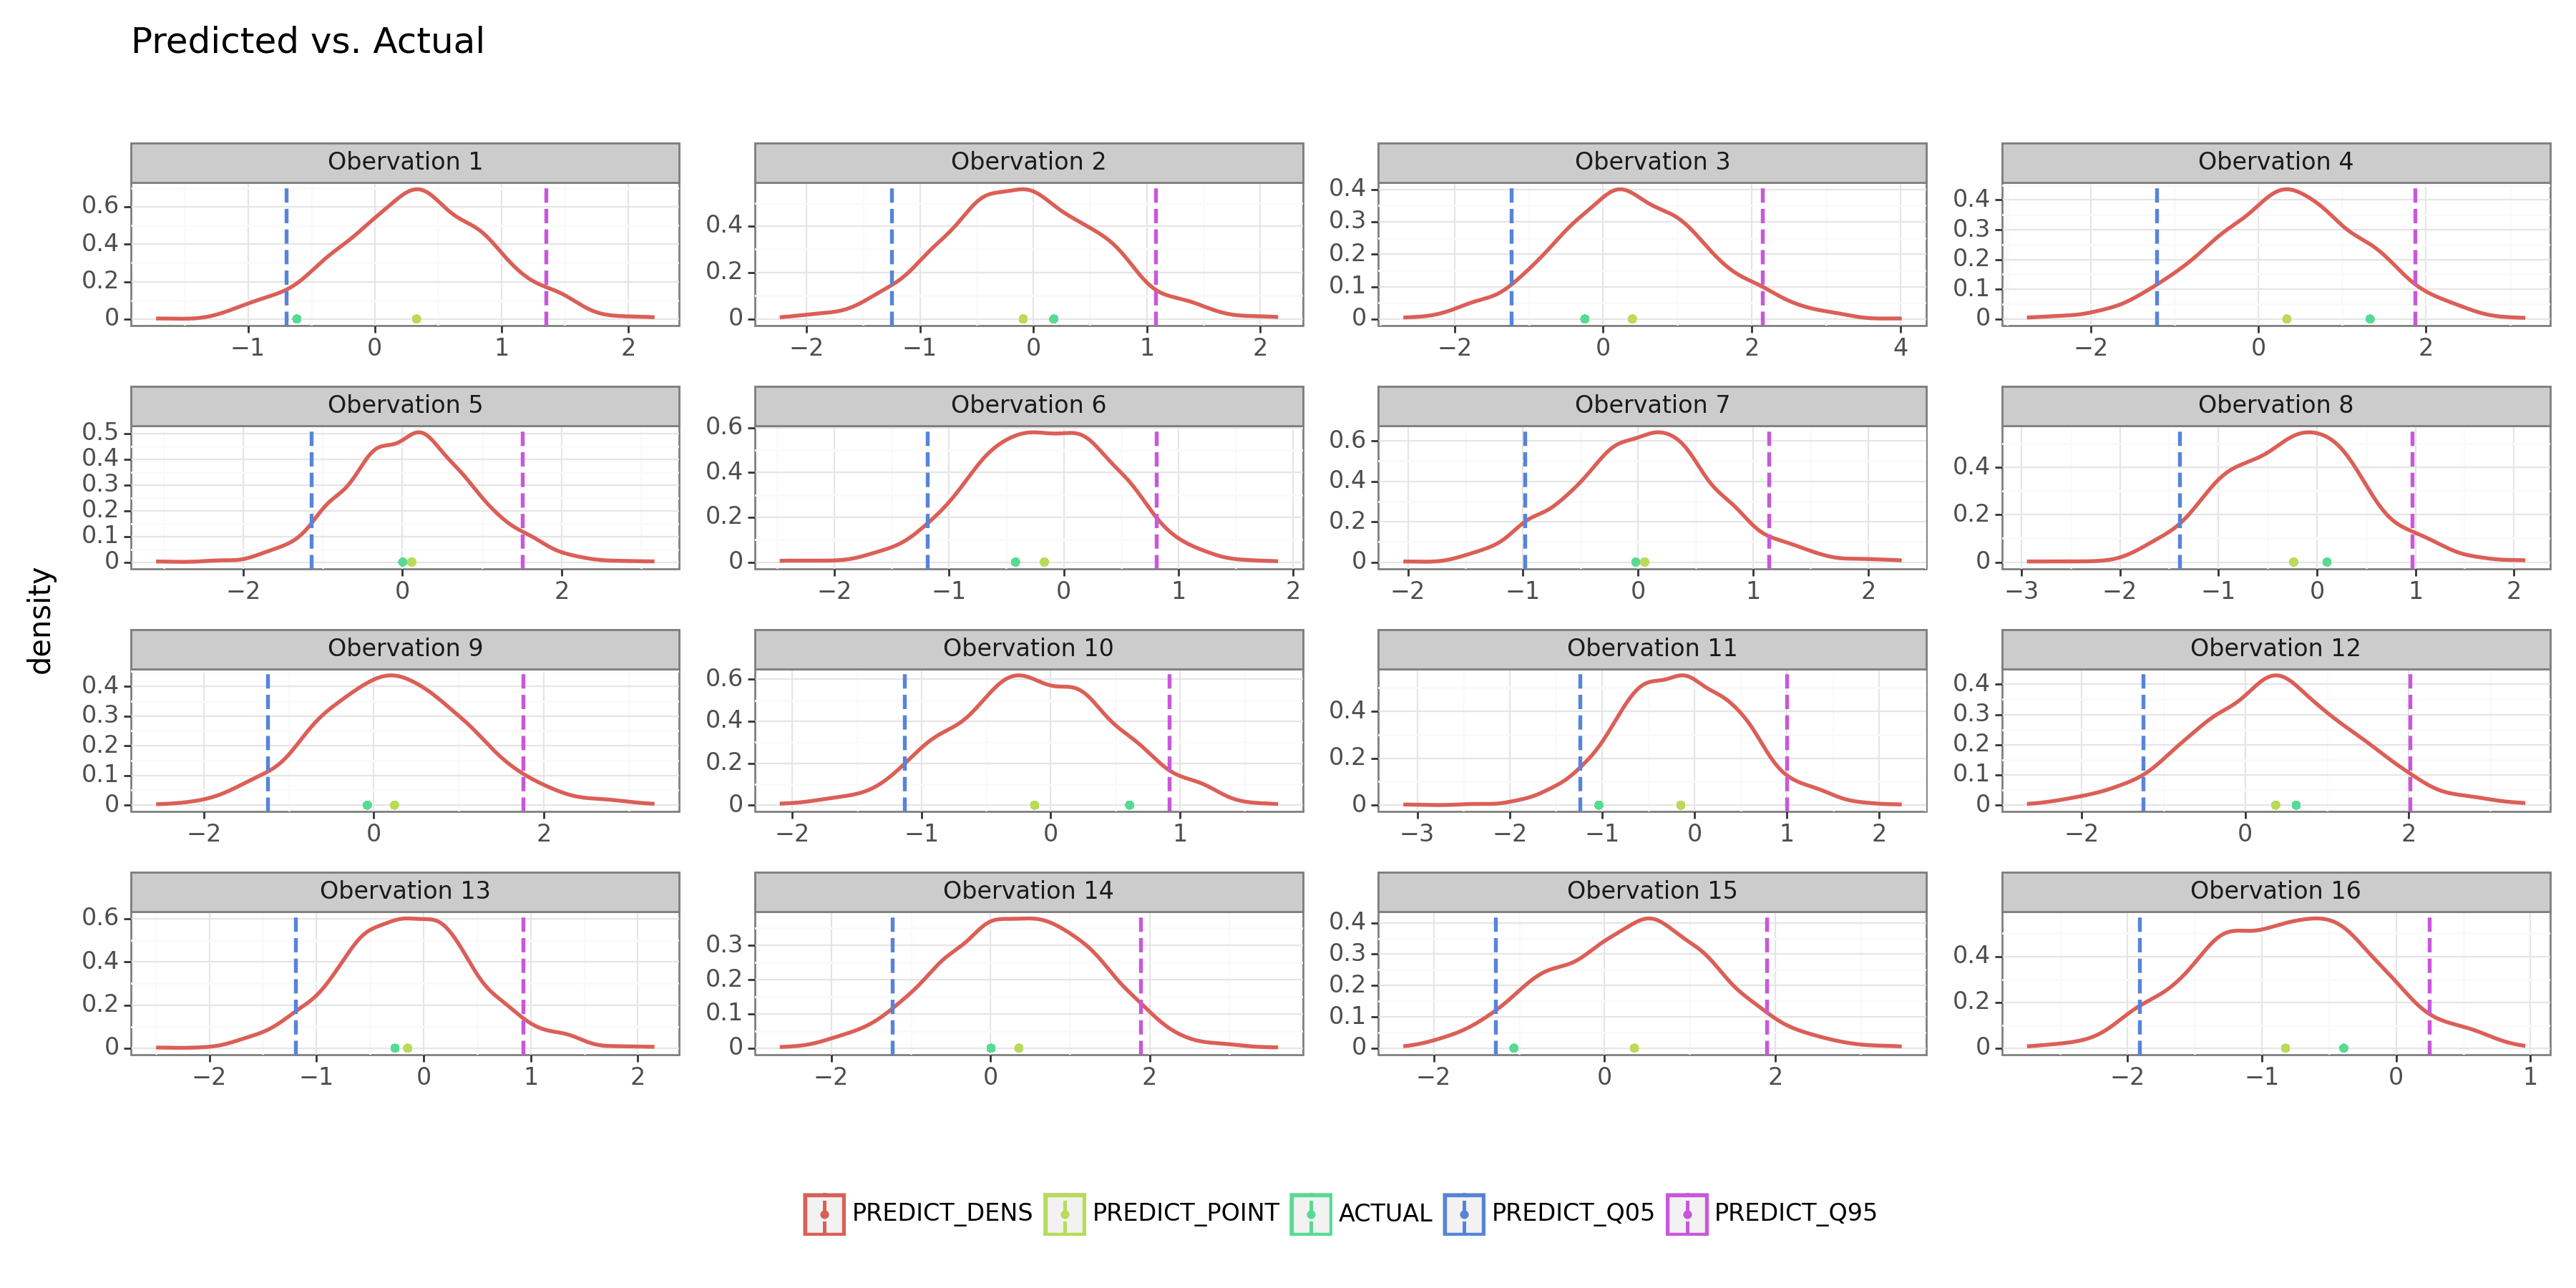

In [16]:
y_pred = []

n_examples = 16
q_sel = [0.05, 0.95]
y_sel=0
samples_arr = pred_samples.drop(columns="target").values.reshape(n_targets,-1,n_samples)

for i in range(n_examples):    
    y_samples = pd.DataFrame(samples_arr[y_sel,i,:].reshape(-1,1), columns=["PREDICT_DENS"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENS"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENS"].quantile(q=q_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENS"].quantile(q=q_sel[1])
    y_samples["ACTUAL"] = y_test[i,y_sel]
    y_samples["obs"]= f"Obervation {i+1}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
pred_df["obs"] = pd.Categorical(pred_df["obs"], categories=[f"Obervation {i+1}" for i in range(n_examples)])
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free",
               ncol=4) + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          legend_title = element_blank()
         )
)

print(plot_pred)